<a href="https://colab.research.google.com/github/toyokawaxyz/forex/blob/main/main__ver5_data_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from scipy.stats import norm
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV,KFold
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns
from sklearn import svm
import keras
from keras import backend as K
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN
from sklearn.pipeline import Pipeline
from keras import metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping 
 
# Early-stopping 
early_stopping = EarlyStopping(patience=0, verbose=1) 



%matplotlib inline

In [26]:
lambda_ = 0.94   #モルガンスタンレーが採用しているEWMAに用いる重みの定数
alpha = 0.95    #標準正規分布の有効範囲のパラメータ 0.95なら95%点

#2 データの記述統計、前処理、調整、テストで関数を分けておいた方が、後に一部変更が発生したときに対処しやすい

class Calc():

  def __init__(self, data):
    self.data = data
 #---------------------------------------------------------前処理--------------------------- 
  def Preprocessing(self):
    data = pd.read_csv(self.data,names=("Results","High","Low","Close"),skiprows=8)
    train= data[:-365]
    test=data[-365:]
    test.reset_index(inplace=True, drop=True)
    #-------------------------------記述統計----------------------------------------
    print("traindata_記述統計",train.describe())
    print("testdata_記述統計",test.describe())
    print("(正規化前)","train.shape:",train.shape,"test.shape:",test.shape)

    #VaR計算用に終値を代入(t=train data,   k = test data)
    close_t = train["Close"]
    close_k = test["Close"]

    #-------------------------------------------正規化のための計算-----------------
    # rの算出
    train["r"] = None
    for t in range(1,len(close_t)):
      train["r"][t] =np.log(close_t[t]/close_t[t-1])
    #（1）式により出たNoneが含まれている行を除外  つまりは最初の1行を除外
    train =train.dropna(subset=["r"])
    print(train.shape)

    r_ = sum(train["r"])/len(train["r"])   #r_の算出(つまりはr_iの平均)
    #σ^2の算出
    s2 =sum((train["r"]- r_)**2) /len(train["r"])       
    train["s2"] =s2
    # r_t == r_i[-1]
    train["r_t"] = None
    r_t= train["r"][-1:]
    train["r_t"]= train["r_t"].where(train["r_t"]==all, r_t.values)
    #σ^2（t+1）　＝（1-λ）*r^2 + λ*σ^2
    train["s2_tplus1"] = (1-lambda_) * train["r_t"]**2  + lambda_*s2 
    # φ^-1
    phi_inverse =norm.ppf(alpha)    
    var_tplus1 = (train["s2_tplus1"]**0.5)* phi_inverse     #VaR_(t+1) = σ^2_(t+1) * φ^(-1) , α=0.99 
    train["var_tplus1"]   = var_tplus1
    #VaR_(t+k) = VaR_(t+1) * √k   /高値 , k= （テストデータの長さ)
    var_tplusk = (var_tplus1) * (len(test)**0.5) 

    #max_(t+k)   = y_t * { 1 + var_(t+k)} 
    y_t= train["Close"][-1:].values
    max_tplusk = y_t * (1+ var_tplusk)
    #min_(t+k)
    min_tplusk = y_t * (1- var_tplusk)

    #Max_(global)
    max_y = max(train["High"])
    max_var = max(max_tplusk)
    max_global =max(max_var, max_y)
    #Min_(global)
    min_y = min(train["Low"])
    min_var = min(min_tplusk)
    min_global= min(min_var, min_y)
    
    #y'_(i) = {y_(i) - Min_(global)}/{Max_(global) - Min_(global)}
    y_i_dash = (train["Close"] - min_global)   / (max_global - min_global)   
    train["y_i_dash"] = y_i_dash
    #y'_(j) = {y_(j) - Min_(global)}/{Max_(global) - Min_(global)}
    y_j_dash = (test["Close"] - min_global)   / (max_global - min_global)  
    test["y_j_dash"] = y_j_dash
    #------------------------------正規化したデータの訓練etc.------------------------------------------
    data_train = pd.DataFrame()
    data_train["time"] = train["Results"]
    data_train["value"]  = train["y_i_dash"]
    data_train["lag_1"]  = train["y_i_dash"].shift(1)
    data_train["lag_2"]  = train["y_i_dash"].shift(2)
    data_train["lag_3"]  = train["y_i_dash"].shift(3)
    data_train["lag_4"]  = train["y_i_dash"].shift(4)
    data_train["lag_5"]  = train["y_i_dash"].shift(5)
    data_train = data_train.dropna()
    data_train.reset_index(inplace=True, drop=True)

    data_test= pd.DataFrame()
    data_test["time"] = test["Results"]
    data_test["value"] = test["y_j_dash"]
    data_test["lag_1"] = test["y_j_dash"].shift(1)
    data_test["lag_2"] = test["y_j_dash"].shift(2)
    data_test["lag_3"] = test["y_j_dash"].shift(3)
    data_test["lag_4"] = test["y_j_dash"].shift(4)
    data_test["lag_5"] = test["y_j_dash"].shift(5)
    data_test = data_test.dropna()
    data_test.reset_index(inplace=True, drop=True)
    #-----------------------------------------------------------------------------------
    #--------train data , test data---------------------------------------------
    X_train = data_train[["lag_1", "lag_2", "lag_3", "lag_4","lag_5"]].values
    y_train =data_train["value"].values

    X_test =data_test[["lag_1", "lag_2", "lag_3", "lag_4","lag_5"]].values
    y_test= data_test["value"].values
    #------------------------testのx軸-------------------------------------------------------------
    time_test = pd.DataFrame()
    time_test =data_test["time"]


    #--------------------------cross validation--------
    kf = KFold(n_splits=5, shuffle=True)

    for train_index, eval_index in kf.split(X_train):
      X_tra, X_eval = X_train[train_index], X_train[eval_index]
      y_tra, y_eval = y_train[train_index], y_train[eval_index]
    print(X_tra,X_eval)


    return X_train,X_test, y_train,y_test,min_global,max_global , test, time_test

  
  #-------------------------------------正規化したデータの復元-----------------------------------------------------------------
  def repair(self,min_global,max_global, y_test_pred):
    #正規化されている予測データを戻す(テストデータ) 
    y_j = min_global + y_test_pred * (max_global - min_global)
    return y_j




#RMSE定義
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
    


#-------------------------------------結果 plot---------------------------------------------------- 
def result(test,y_j,time_test):
  
  ticks = 30
  plt.xticks(rotation=90)
  plt.xticks(range(0, len(time_test), ticks), time_test[::ticks])

  plt.plot(test["Close"][5:],label="actual")
  plt.plot(y_j,label="predict")
  plt.legend()  
  plt.show()
  #print(test["Close"][5:] ,y_j)
  
  mae = mean_absolute_error(test["Close"][5:] ,y_j)
  print('MAE : {:.5f}'.format(mae))
  rmse = np.sqrt(mean_squared_error(test["Close"][5:] ,y_j))
  print('RMSE : {:.5f}'.format(rmse))


#--------------------------------------------------random forest --------------------------------------------------
def RF(X_train,X_test,y_train,params=0):
  print("RF")

  forest = RandomForestRegressor(params,verbose=1,n_jobs=-1)
  forest.fit(X_train,y_train)
  y_test_pred = forest.predict(X_test)
  return y_test_pred
#------------------------------------SVM------------------------------------------------------------
def SVM(X_train,X_test,y_train):

  print("SVM")
  SVR_model = svm.SVR(kernel="linear",gamma=0.001,max_iter=5000,verbose=1)
  
  SVR_model.fit(X_train,y_train,)
  y_test_pred = SVR_model.predict(X_test)
  
  return y_test_pred


#---------------------------------NN パラメータ等--------------------------------------
n_in = 5  # 入力層のニューロン数
n_mid = 16  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数


#--------------------------------------MLP------------------------------------------------------------------
def MLP(X_train,X_test,y_train,y_test,function):
  print("MLP:",function)
  # 入力層、中間層、出力層の３層のニューラルネットワークを構築する
  model = Sequential()
  model.add(Dense(n_mid, input_shape=(n_in,), activation=function))  
  model.add(Dense(n_out, activation="linear"))  
  model.compile(loss = root_mean_squared_error, optimizer= keras.optimizers.Adam(learning_rate=0.001))  
  

  #学習開始
  history =model.fit( X_train , y_train,batch_size=64 ,epochs=3000, validation_split=0.2, verbose=0,callbacks=[early_stopping]) 
  #pd.DataFrame(history.history).plot()

  y_test_pred = model.predict(X_test)
  
  
  return y_test_pred



#--------------------------------------------RNN--------------------------------------------




#--------------------------------------------FOREX-----------------------------------


def forex(model_select,data):
  
  forex =Calc(data)

  X_train,X_test, y_train,y_test, min_global,max_global,test, time_test = forex.Preprocessing()
  

  if model_select in {"SVM"}:
    y_test_pred =SVM(X_train,X_test,y_train)
    y_j = forex.repair(min_global,max_global,y_test_pred)
    result(test,y_j,time_test)
  elif model_select in {"RF"}:
    y_test_pred =RF(X_train,X_test,y_train,params)
    y_j = forex.repair(min_global,max_global,y_test_pred)
    result(test,y_j,time_test)
  elif model_select in {"MLP"}:
    functions =("tanh","relu","linear","swish","sigmoid")
    #functions =("tanh",)
    for function in functions:

      y_test_pred =MLP(X_train,X_test,y_train,y_test,function)
      y_j = forex.repair(min_global,max_global,y_test_pred)
      result(test,y_j,time_test)

  elif model_select in {"SVM_grid"}:
    y_test_pred = SVM_grid(X_train,X_test,y_train)
    y_j = forex.repair(min_global,max_global,y_test_pred)
    result(test,y_j,time_test)
    

  elif model_select in {"RF_grid"}:
    y_test_pred = RF_grid(X_train,X_test,y_train)
    y_j = forex.repair(min_global,max_global,y_test_pred)
    result(test,y_j,time_test)


#--------------------------------パラメータチューニング---------------------------




def RF_grid(X_train,X_test,y_train):
  print("RF_gridsearch")
  n_estimators= [500,1500,3000]
  max_depth=[2,5,8]
  min_samples_split =[2,5,8]
  min_samples_leaf=[2,5,8]
  param_grid = dict(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
  print(param_grid)
  RF= RandomForestRegressor()
  grid= GridSearchCV(RF,param_grid=param_grid,cv=5,n_jobs=-1,refit=True)
  grid.fit(X_train,y_train)
  y_test_pred = grid.predict(X_test)
  #print(grid_cv.best_params_)
  #print(grid_cv.best_score_)
  
  return y_test_pred


def SVM_grid(X_train,X_test,y_train):
  print("SVM_gridsearch")
  """
  Cs= [0.001,0.01,0.1,1,10,100,1000]
  gammas=[0.001,0.01,0.1,1,10,100,1000]
  """
  Cs= [100,300,500,700,900]
  gammas=[0.001,0.002,0.003,0.004]
  param_grid = dict(gamma=gammas,C=Cs)
  
  SVR_model = svm.SVR()
  grid= GridSearchCV(SVR_model,param_grid=param_grid,cv=5,n_jobs=-1,refit=True)
  
  grid.fit(X_train,y_train)
  print(grid.best_params_)


  y_test_pred = grid.predict(X_test)
  #print(grid_cv.best_params_)
  #print(grid_cv.best_score_)
  
  return y_test_pred


In [27]:
EURUSD ="/content/drive/MyDrive/rate/eurusd2000_2019august_all.csv"
USDJPY ="/content/drive/MyDrive/rate/usdjpy2000_2019august_all.csv"
GBPUSD ="/content/drive/MyDrive/rate/gbpusd2000_2019august_all.csv"
USDCHF ="/content/drive/MyDrive/rate/usdchf2000_2019august_all.csv"
AUDUSD ="/content/drive/MyDrive/rate/audusd2000_2019august_all.csv"
USDCAD ="/content/drive/MyDrive/rate/usdcad2000_2019august_all.csv"

In [28]:
forex_list =(EURUSD,USDJPY,USDCHF,GBPUSD,USDCAD,AUDUSD)

traindata_記述統計               High          Low        Close
count  4765.000000  4765.000000  4765.000000
mean    106.271742   106.751620   105.768978
std      13.775231    13.808399    13.733553
min      75.720000    76.000000    75.550000
25%      98.240000    98.850000    97.640000
50%     108.720000   109.182000   108.250000
75%     117.530000   117.960000   117.020000
max     134.780000   135.150000   134.100000
testdata_記述統計             High         Low       Close
count  365.00000  365.000000  365.000000
mean   110.30411  110.604164  109.961973
std      2.00546    1.989408    2.043583
min    105.29000  105.700000  104.480000
25%    108.65000  109.000000  108.380000
50%    110.56000  110.860000  110.270000
75%    111.71000  112.020000  111.400000
max    114.31000  114.550000  113.660000
(正規化前) train.shape: (4765, 4) test.shape: (365, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(4764, 5)
[[0.48230691 0.49166383 0.4763525  0.45678802 0.4329704 ]
 [0.49421572 0.48230691 0.49166383 0.4763525  0.45678802]
 [0.50408302 0.49421572 0.48230691 0.49166383 0.4763525 ]
 ...
 [0.5045934  0.51241919 0.51497108 0.49897924 0.50017013]
 [0.50510378 0.5045934  0.51241919 0.51497108 0.49897924]
 [0.52245662 0.50510378 0.50510378 0.5045934  0.51241919]] [[0.49574685 0.48996257 0.48792106 0.50255189 0.50102076]
 [0.48826131 0.48400817 0.49625723 0.49574685 0.48996257]
 [0.50255189 0.50187138 0.48826131 0.48400817 0.49625723]
 ...
 [0.50952705 0.51003743 0.50476353 0.50340252 0.50663491]
 [0.49897924 0.50017013 0.48707043 0.48741068 0.49795849]
 [0.50510378 0.50510378 0.5045934  0.51241919 0.51497108]]
MLP: tanh


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 00011: early stopping


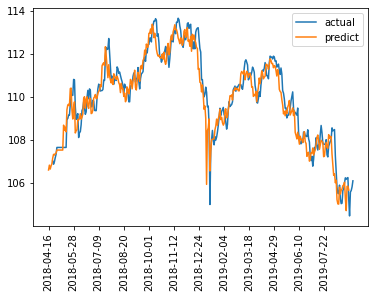

MAE : 0.40109
RMSE : 0.53379
MLP: relu
Epoch 00002: early stopping


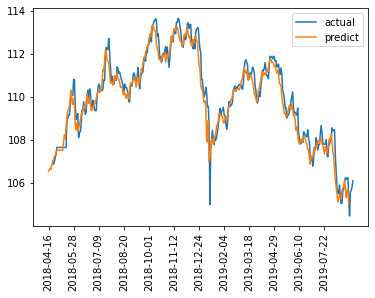

MAE : 0.50774
RMSE : 0.65395
MLP: linear
Epoch 00006: early stopping


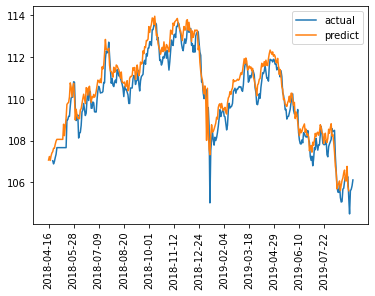

MAE : 0.58241
RMSE : 0.79135
MLP: swish
Epoch 00004: early stopping


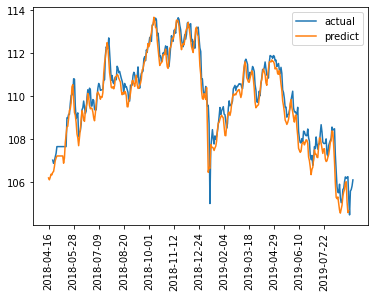

MAE : 0.77134
RMSE : 0.95117
MLP: sigmoid
Epoch 00008: early stopping


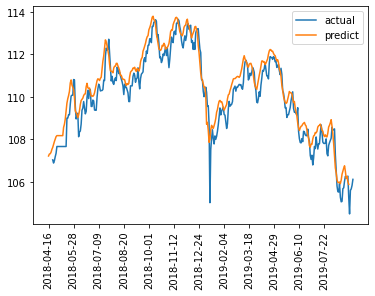

MAE : 0.56413
RMSE : 0.76328


In [29]:
forex("MLP",USDJPY)

In [12]:
forex("MLP",GBPUSD)

traindata_記述統計               High         Low        Close
count  4765.000000  4765.00000  4765.000000
mean      1.615163     1.62185     1.608280
std       0.194189     0.19453     0.194032
min       1.205410     1.20853     1.152240
25%       1.482600     1.49300     1.474500
50%       1.587100     1.59190     1.580500
75%       1.745800     1.75300     1.738400
max       2.108500     2.11600     2.097400
testdata_記述統計              High         Low       Close
count  365.000000  365.000000  365.000000
mean     1.296450    1.302413    1.292249
std      0.040424    0.040216    0.039785
min      1.205000    1.209800    1.201600
25%      1.271600    1.276800    1.268100
50%      1.299100    1.304700    1.294100
75%      1.316800    1.321700    1.309900
max      1.432700    1.437800    1.428500
(正規化前) train.shape: (4765, 4) test.shape: (365, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(4764, 5)
[[0.51414621 0.51680562 0.52232901 0.51670333 0.51210051]
 [0.51721476 0.51414621 0.51680562 0.52232901 0.51670333]
 [0.52590898 0.51721476 0.51414621 0.51680562 0.52232901]
 ...
 [0.27745869 0.27735641 0.27664041 0.27643584 0.28267523]
 [0.27684498 0.27745869 0.27735641 0.27664041 0.27643584]
 [0.27183302 0.27684498 0.27745869 0.27735641 0.27664041]] [[0.51056623 0.51343021 0.52151073 0.52590898 0.51721476]
 [0.51210051 0.51056623 0.51343021 0.52151073 0.52590898]
 [0.52856839 0.52335186 0.51741933 0.51210051 0.51056623]
 ...
 [0.25025088 0.26058167 0.2678439  0.26549135 0.26047938]
 [0.25137602 0.2501486  0.24564806 0.25025088 0.26058167]
 [0.25955882 0.25638798 0.25137602 0.2501486  0.24564806]]
MLP: tanh


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AttributeError: ignored

In [ ]:
forex("MLP",USDCAD)

In [ ]:
for forex_csv in forex_list:
  print(forex_csv)
  forex("SVM_grid",forex_csv)

In [ ]:
forex("SVM_grid",EURUSD)

In [ ]:
forex("SVM_grid",GBPUSD)

In [ ]:
forex("SVM_grid",USDJPY)

In [ ]:
forex("SVM_grid",USDCHF)

In [ ]:
forex("SVM",USDCHF)

In [ ]:
forex("RF_grid",GBPUSD)

In [ ]:
forex("RF_grid",USDJPY)

In [ ]:
forex("SVM",GBPUSD)

